- Pull in results from dynamo/hot
- Pull in predictions from sql, filter for stuff older than 5 hours
- apply "true" labels based on what is in the dynamo data. One for anything that is in the dynamo/hot table, one for anything that has at least a score of 10k.
- plot performance metrics

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Set-up" data-toc-modified-id="Set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Set up</a></span></li><li><span><a href="#Pull-in-Dynamo-Hot-Data" data-toc-modified-id="Pull-in-Dynamo-Hot-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Pull in Dynamo Hot Data</a></span></li><li><span><a href="#Pull-in-SQL-data" data-toc-modified-id="Pull-in-SQL-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Pull in SQL data</a></span></li><li><span><a href="#Join-data-and-create-true-value-labels" data-toc-modified-id="Join-data-and-create-true-value-labels-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Join data and create true value labels</a></span></li><li><span><a href="#Plot-performance-metrics" data-toc-modified-id="Plot-performance-metrics-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Plot performance metrics</a></span></li></ul></div>

## Set up

In [15]:
import modelUtils as mu
from datetime import datetime, timedelta
import sys
import os
#THIS_DIR = os.path.dirname(os.path.abspath(__file__))
#sys.path.append(os.path.join(THIS_DIR, '../'))
sys.path.append('../')
import configUtils as cu
import boto3
from pyspark.sql import SparkSession
import pandas as pd
import sqlUtils as su

In [11]:
os.environ['TZ'] = 'UTC'


cfg_file = cu.findConfig()
cfg = cu.parseConfig(cfg_file)


spark = (
  SparkSession
  .builder
  .appName('redditData')
  .config('spark.driver.extraJavaOptions', '-Duser.timezone=GMT')
  .config('spark.executor.extraJavaOptions', '-Duser.timezone=GMT')
  .config('spark.sql.session.timeZone', 'UTC')
  .config("fs.s3a.access.key", cfg['S3_access']['ACCESSKEY'])
  .config("fs.s3a.secret.key", cfg['S3_access']['SECRETKEY'])
  .getOrCreate()
)

dynamodb_resource = boto3.resource('dynamodb', region_name='us-east-2')

engine = su.makeEngine(cfg)

## Pull in Dynamo Hot Data

In [13]:
now = datetime.now()
twoDaysAgo = now - timedelta(days=2)
twoDaysAgoDate = twoDaysAgo.date()
datesToQuery = mu.daysUntilNow(twoDaysAgoDate)

hotTable = dynamodb_resource.Table('hot')

postIdQueryResult = mu.queryByRangeOfDates(hotTable, datesToQuery)
hotPosts = mu.queryByRangeOfDates(hotTable, datesToQuery)
uniqueHotPostIds = set([p['postId'] for p in hotPosts])
print("Number of posts found:", len(uniqueHotPostIds))

Number of posts found: 120


In [29]:
# we mainly need this for making a target around score
hotPostsData = mu.getPostIdPdDataFrame(
  table=hotTable
  , postIds=uniqueHotPostIds
  , chunkSize=100
  , flatten=True
)

In [50]:
hotPostMaxScore = hotPostsData[['postId', 'subreddit', 'score']].groupby(['postId', 'subreddit']).max().reset_index(drop=False).rename(columns={'score':'hotPostMaxScore', 'subreddit':'hotPostSubreddit'})
hotPostMaxScore.head()

,postId,hotPostSubreddit,hotPostMaxScore
0,12k6m37,funny,350
1,12ondqr,aww,1678
2,132h290,movies,232
3,134io09,funny,81
4,13878rl,movies,3667


Learned from this that stickied posts are ending up in the hot view, made a patch for that, going forward should get a better selection of posts for subreddits that have stickied posts.

## Pull in SQL data

In [73]:
twoDaysAgoStr = twoDaysAgo.strftime('%Y-%m-%d %H:%M:%S')
# this accounts for lags in posts hitting the front page
sixHoursAgo = now-timedelta(hours=6)
sixHoursAgoStr = sixHoursAgo.strftime('%Y-%m-%d %H:%M:%S')
query = f"""SELECT
  *
FROM
  public."scoredData"
WHERE
  "createdTSUTC" >= '{twoDaysAgoStr}'
  AND "createdTSUTC" <= '{sixHoursAgoStr}' 
"""
recentlyScoredData = pd.read_sql(query, engine)
print(len(recentlyScoredData))
recentlyScoredData.head()

3300


,postId,subreddit,title,createdTSUTC,maxScore20m,maxScore21_40m,maxScore41_60m,maxNumComments20m,maxNumComments21_40m,maxNumComments41_60m,...,maxUpvoteRatio21_40m,maxUpvoteRatio41_60m,maxNumGildings20m,maxNumGildings21_40m,maxNumGildings41_60m,maxScoreGrowth21_40m41_60m,maxNumCommentsGrowth21_40m41_60m,predict_proba_1,stepUp,modelName
0,13f2gey,memes,Hashtag badass,2023-05-11 22:35:34,11,11,11,1,1,1,...,0.87,0.87,0,0,0,0.000000,0.0,0.01647,0,models/Reddit_model_20230503-235329_GBM.sav
1,13eybbo,pics,Once I noticed it. I had to do it lol,2023-05-11 20:03:53,7,7,7,0,0,0,...,0.89,0.77,0,0,0,0.000000,0.0,0.01647,0,models/Reddit_model_20230503-235329_GBM.sav
2,13ey6tm,aww,"Another day, another collection of random stuf...",2023-05-11 19:59:35,4,9,12,0,0,0,...,0.91,0.93,0,0,0,0.333333,0.0,0.01647,0,models/Reddit_model_20230503-235329_GBM.sav
3,13erc7c,funny,Corn is better than lobster FACT,2023-05-11 15:54:28,2,0,0,1,0,0,...,0.00,0.00,0,0,0,0.000000,0.0,0.01647,0,models/Reddit_model_20230503-235329_GBM.sav
4,13e2qal,funny,Funny song and music video!,2023-05-10 20:47:07,3,3,1,2,2,2,...,0.80,0.57,0,0,0,-0.666667,0.0,0.01647,0,models/Reddit_model_20230503-235329_GBM.sav


## Join data and create true value labels

In [86]:
mergedDf = pd.merge(recentlyScoredData, hotPostMaxScore, on=['postId'], how='outer')
mergedDf['coalesceSubreddit'] = mergedDf[['subreddit', 'hotPostSubreddit']].bfill(axis=1).iloc[:, 0]
mergedDf['hotPost'] = mergedDf['hotPostMaxScore'].apply(lambda x: 0 if pd.isna(x) else 1)
mergedDf['hotPost10k'] = mergedDf['hotPostMaxScore'].apply(lambda x: 0 if pd.isna(x) or x<10000 else 1)
mergedDf['stepUp'] = mergedDf['stepUp'].fillna(0).apply(int)
mergedDf['stepUp&HotPost'] = mergedDf['stepUp']&mergedDf['hotPost']
mergedDf['stepUp&HotPost10k'] = mergedDf['stepUp']&mergedDf['hotPost10k']


In [94]:
mergedDf[['coalesceSubreddit', 'stepUp']].groupby('coalesceSubreddit').count().rename(columns={'stepUp':'count'})

,count
coalesceSubreddit,
aww,608
funny,218
gaming,232
memes,904
movies,223
news,112
pics,583
todayilearned,129
worldnews,339


In [95]:
metricsDf = mergedDf[['coalesceSubreddit', 'stepUp', 'hotPost', 'hotPost10k', 'stepUp&HotPost', 'stepUp&HotPost10k']].groupby('coalesceSubreddit').agg('sum')
metricsDf['recall_hotPost'] = metricsDf['stepUp&HotPost']/metricsDf['hotPost']
metricsDf['precision_hotPost'] = metricsDf['stepUp&HotPost']/metricsDf['stepUp']
metricsDf['recall_hotPost10k'] = metricsDf['stepUp&HotPost10k']/metricsDf['hotPost10k']
metricsDf['precision_hotPost10k'] = metricsDf['stepUp&HotPost10k']/metricsDf['stepUp']
metricsDf = metricsDf.sort_values('recall_hotPost10k', ascending=False)
metricsDf

,stepUp,hotPost,hotPost10k,stepUp&HotPost,stepUp&HotPost10k,recall_hotPost,precision_hotPost,recall_hotPost10k,precision_hotPost10k
coalesceSubreddit,,,,,,,,,
worldnews,21,14,8,7,5,0.500000,0.333333,0.625000,0.238095
aww,14,13,8,5,4,0.384615,0.357143,0.500000,0.285714
pics,6,16,11,5,5,0.312500,0.833333,0.454545,0.833333
todayilearned,13,14,11,5,5,0.357143,0.384615,0.454545,0.384615
news,18,13,9,5,4,0.384615,0.277778,0.444444,0.222222
funny,11,10,7,3,3,0.300000,0.272727,0.428571,0.272727
memes,16,18,8,4,3,0.222222,0.250000,0.375000,0.187500
movies,5,9,3,1,1,0.111111,0.200000,0.333333,0.200000
gaming,5,13,7,2,2,0.153846,0.400000,0.285714,0.400000


## Plot performance metrics

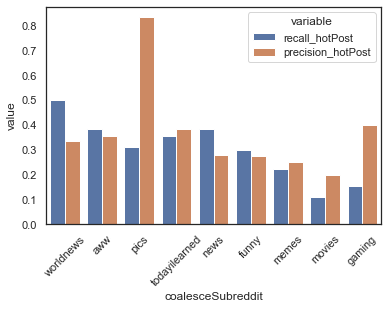

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

meltedDf = metricsDf.reset_index(drop=False).melt(id_vars='coalesceSubreddit', value_vars=['recall_hotPost', 'precision_hotPost'])

sns.set(style='white')
sns.barplot(data=meltedDf, x='coalesceSubreddit', y='value', hue='variable')
plt.xticks(rotation=45)
plt.show()

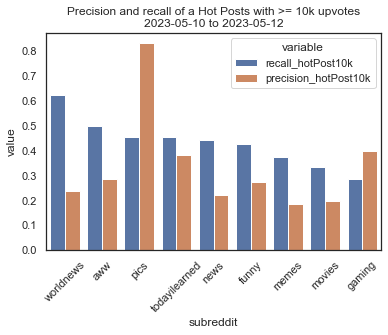

In [103]:

meltedDf = metricsDf.reset_index(drop=False).melt(id_vars='coalesceSubreddit', value_vars=['recall_hotPost10k', 'precision_hotPost10k'])

sns.set(style='white')
sns.barplot(data=meltedDf, x='coalesceSubreddit', y='value', hue='variable')
plt.xticks(rotation=45)
plt.xlabel('subreddit')
plt.title('Precision and recall of a Hot Posts with >= 10k upvotes\n2023-05-10 to 2023-05-12')
plt.show()

hotPost10k is basically "did a post reach the top 3 on the subreddit and did it have a max score of at least 10k." This is more strict than how the current model (2023-05-12) trains which does not have the 10k limit. It can make the recall look better than "hotPost" because there are fewer targets to predict correctly.  Precisions can be lower in some cases because there are fewer true targets to match out of everything predicted to step up.